# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

# 1. Подготовка

### 1.1 Загрузим необходимые библиотеки, датасет и получим общую информацию 

In [1]:
import pandas as pd
import xgboost as xgb
import catboost as ctb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import make_scorer
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import StandardScaler

/Users/aleksandrsaraev/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data = pd.read_csv('/Users/aleksandrsaraev/project/21_07_2020/taxi.csv')
#data = pd.read_csv('/datasets/taxi.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


1. В датасете представлено 26496 строк и 1 столбец - время и количество заказов
2. Пропусков нет

### 1.2 Переведем дату в тип данных datetime

In [3]:
data['datetime'] = pd.to_datetime(data['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


### 1.3 Установиv индекс таблицы равным столбцу datetime. 

In [4]:
data.set_index('datetime', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### 1.4 Отсортируем индексы

In [5]:
data.sort_index(inplace=True)
data.index.is_monotonic

True

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Представлены данные от 01 марта 2018 до 31 августа 2018 года, за каждые 10 минут

### 1.5 Выполним ресемплирование по одному часу

In [8]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


# 2. Анализ

### 2.1 Предварительно проанализируем данные через построение графиков со скользящим средним

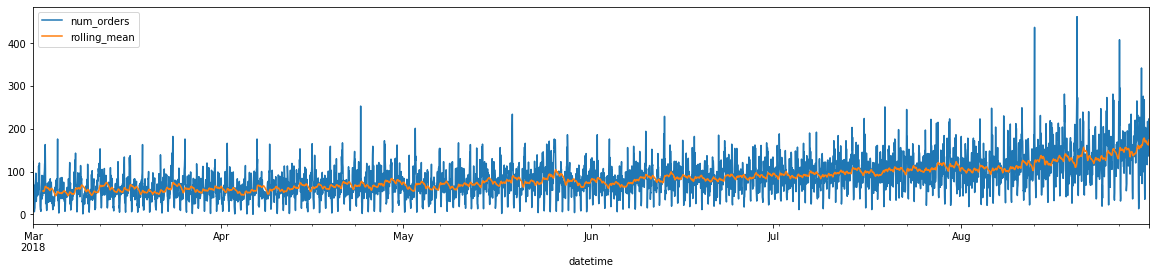

In [9]:
data_rol = data.copy()
data_rol['rolling_mean'] = data_rol.rolling(40).mean()
data_rol.plot(figsize=(20,4))

/Users/aleksandrsaraev/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


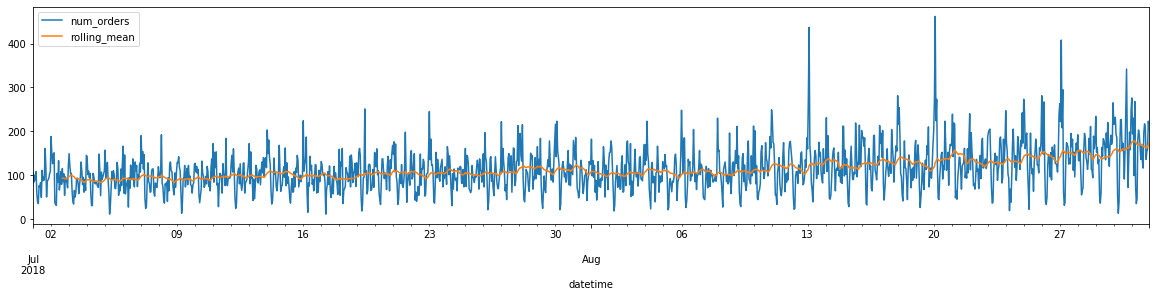

In [10]:
data_jul_aug = data['2018-07':'2018-08']
data_jul_aug['rolling_mean'] = data_jul_aug.rolling(40).mean()
data_jul_aug.plot(figsize=(20,4))

/Users/aleksandrsaraev/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


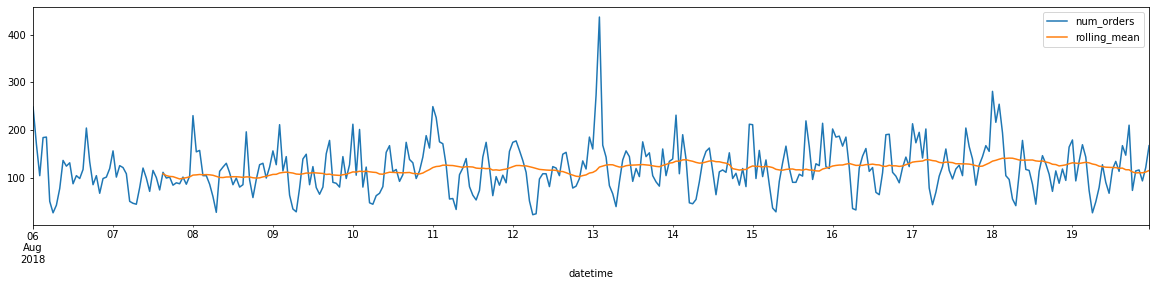

In [11]:
data_aug = data['2018-08-06':'2018-08-19']
data_aug['rolling_mean'] = data_aug.rolling(40).mean()
data_aug.plot(figsize=(20,4))

/Users/aleksandrsaraev/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


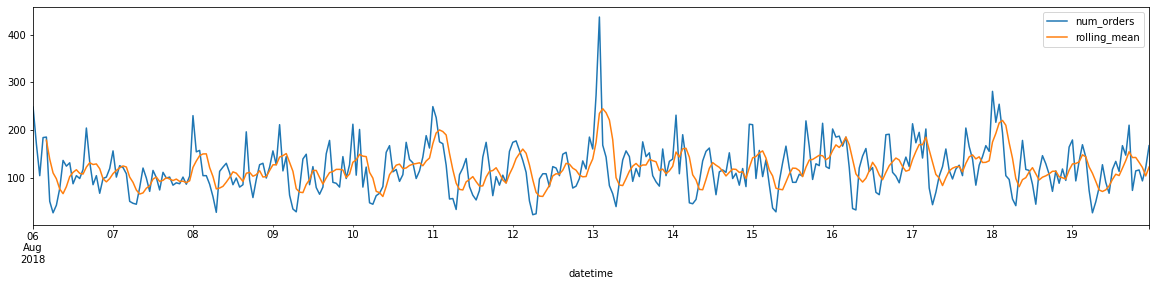

In [12]:
data_aug_19_21 = data['2018-08-06': '2018-08-19']
data_aug_19_21['rolling_mean'] = data_aug_19_21.rolling(5).mean()
data_aug_19_21.plot(figsize=(20,4))

/Users/aleksandrsaraev/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


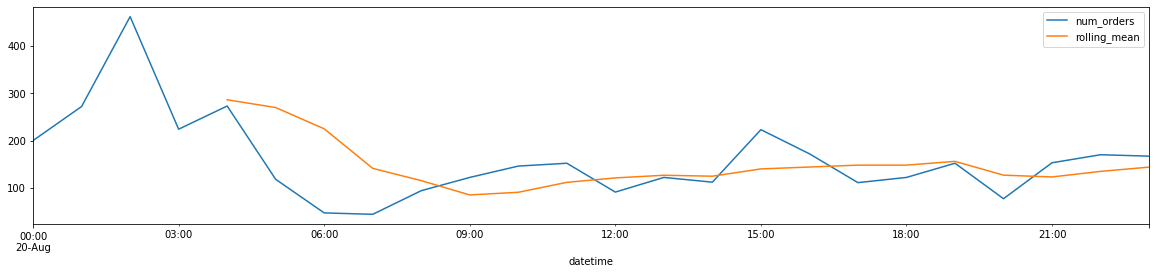

In [13]:
data_aug_20 = data['2018-08-20']
data_aug_20['rolling_mean'] = data_aug_20.rolling(5).mean()
data_aug_20.plot(figsize=(20,4))

In [14]:
data.sort_values(by='num_orders', ascending=False).head(10)

,num_orders
datetime,
2018-08-20 02:00:00,462
2018-08-13 02:00:00,437
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342
2018-08-27 04:00:00,295
2018-08-18 00:00:00,281
2018-08-26 00:00:00,281
2018-08-31 00:00:00,276
2018-08-13 01:00:00,273


Предварительный анализ показал:
1. Число заказов приближаясь к августу растет
2. Максимальные пики потребления такси приходят на августовские понедельники 2 часа ночи. Возможно в эти дни проходили какие-то мероприятия в городе 

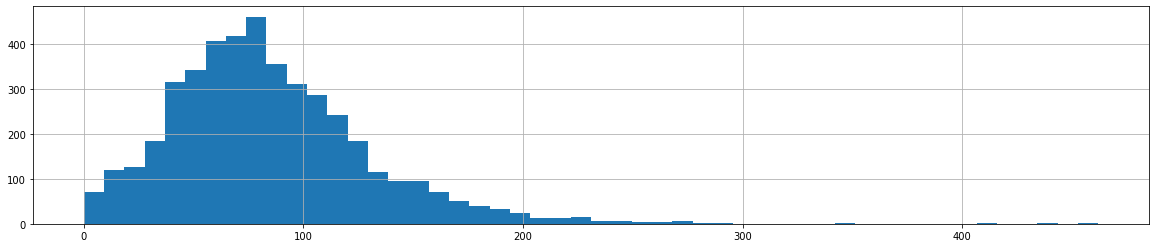

In [15]:
data['num_orders'].hist(figsize=(20,4), bins=50)

In [16]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


В среднем число заказов такси в час составляет около 80. Но имеются и выбросы от 200 до 462 заказов

Посмотрим тренды и сезонности данных

In [17]:
decomposed = seasonal_decompose(data)

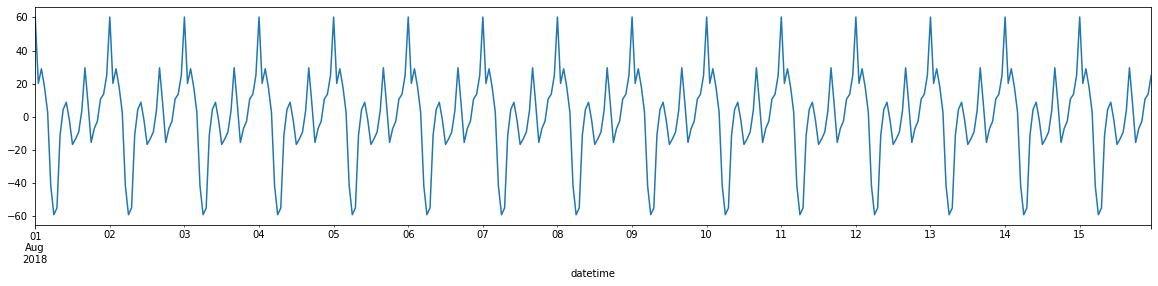

In [18]:
decomposed.seasonal['2018-08-01':'2018-08-15'].plot(figsize=(20,4))

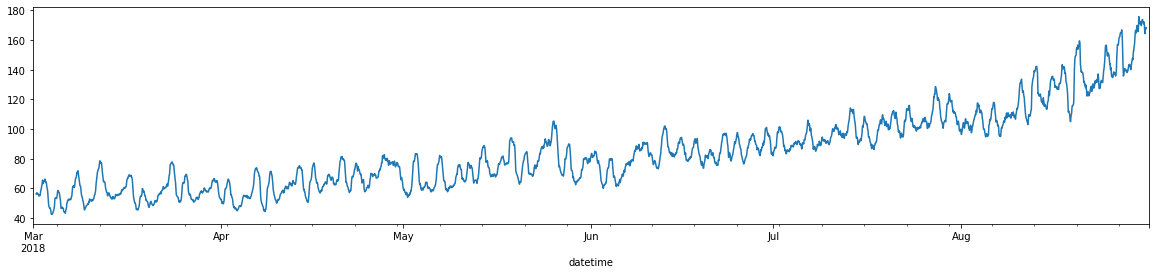

In [19]:
decomposed.trend.plot(figsize=(20,4))

Сезонность - суточная, т.е каждый день цикл повторяется

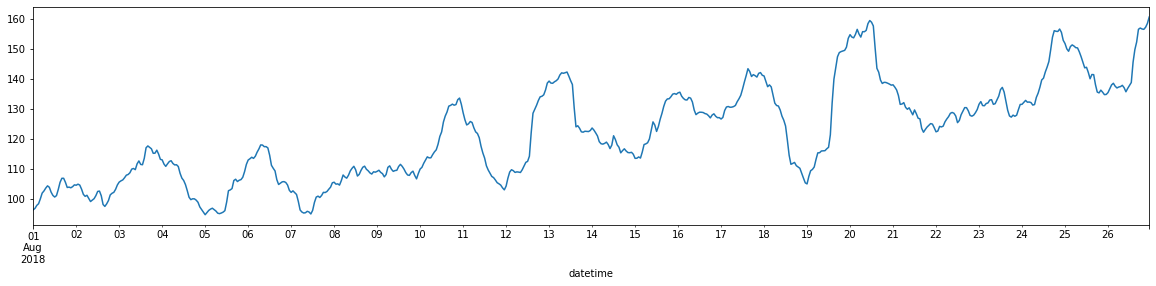

In [20]:
decomposed.trend['2018-08-01':'2018-08-26'].plot(figsize=(20,4))

Трендом является увелечение числа заказов

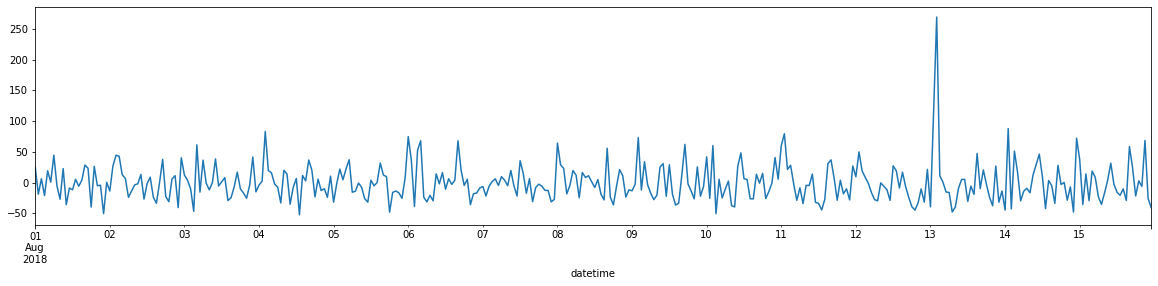

In [21]:
decomposed.resid['2018-08-01':'2018-08-15'].plot(figsize=(20,4))

# 3. Обучение

### 3.1 Создадим признаки

In [22]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


### Выбор признаков:
1) Фактор год: однозначно не подходит. У нас данных меньше года. Поэтому будет просто константа.<br>
2) Фактор месяц: мне кажется подходит, т.к. наблюдается общий рост с каждым месяцем<br>
3) Фактор день: не подходит, т.к. сезонности по дням в месяце не наблюдается<br>
4) Фактор день недели: мне кажется подходит, т.к. в тренде наблюдается разница между продажами в дни недели (большой рост в пятницу, воскресенье)<br>
5) Фактор час: подходит, т.к. сезонность наблюдается именно почасовая<br>
6) Факто lag: подходит, т.к.предыдущие значения временного ряда подскажут, будет ли функция x(t) расти или уменьшаться<br>
7) Фактор rolling: подходит, т.к. скользящее среднее как признак задаёт общий тренд временного ряда<br>    


Проверим работу функции по созданию признаков

In [23]:
make_features(data, 4, 3)
data

,num_orders,hour,month,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,0,3,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,3,71.0,85.0,124.0,NaN,93.333333
2018-03-01 04:00:00,43,4,3,3,66.0,71.0,85.0,124.0,74.000000
...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,8,4,207.0,217.0,197.0,116.0,207.000000
2018-08-31 20:00:00,154,20,8,4,136.0,207.0,217.0,197.0,186.666667
2018-08-31 21:00:00,159,21,8,4,154.0,136.0,207.0,217.0,165.666667


### 3.2 Для обучения примем 3 модели - LinearRegression, LightGBM и Catboost. Подберем оптимальное сочетание признаков для моделей

In [24]:
def metrics(model, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5  
    return rmse

In [25]:
best_features = []
for i in range(1, 31, 2):
    for j in range(1, 31, 5):
        make_features(data, i, j)
        data = data.copy().dropna()
        X_train, X_test, y_train, y_test = train_test_split(
            data.drop('num_orders', axis=1), data['num_orders'], 
            test_size=0.1, shuffle=False)
        model_LR = LinearRegression()
        rmse_LR = metrics(model_LR, X_test, y_test)
        model_ctb = ctb.CatBoostRegressor(verbose=False, random_seed=42)
        rmse_ctb = metrics(model_ctb, X_test, y_test)
        model_lgb = lgb.LGBMRegressor(random_state=42)
        rmse_lgb = metrics(model_lgb, X_test, y_test)
        rmse_mean = (rmse_LR + rmse_ctb + rmse_lgb) / 3
        best_features.append([i, j, rmse_LR, rmse_ctb, rmse_lgb, rmse_mean])
        
best_features = pd.DataFrame(data = best_features,\
                         columns = ['lag', 'rolling_mean_size', 'rmse_LR', 'rmse_ctb', 'rmse_lgb', 'rmse_mean'])\
                         .sort_values(by = 'rmse_mean')
best_features

,lag,rolling_mean_size,rmse_LR,rmse_ctb,rmse_lgb,rmse_mean
84,29,1,45.182597,39.911327,38.412593,41.168839
85,29,6,45.220432,39.467616,39.407381,41.365143
87,29,16,45.476756,40.263159,39.565949,41.768621
86,29,11,45.379574,39.892775,40.276274,41.849541
89,29,26,45.502575,40.981420,40.376444,42.286813
...,...,...,...,...,...,...
7,3,6,54.203659,46.574901,46.520050,49.099537
12,5,1,53.857393,46.889485,46.689949,49.145609
6,3,1,53.903513,47.798865,46.280288,49.327555
0,1,1,53.595488,47.751888,47.146772,49.498049


Для дальнейшего обучения примем 2 модели LightGBM и Catboost. Функцию признаков примем make_features(data, 29, 1)

### 3.3 Подберем оптимальные гиперпараметры для моделей с помощью библиотеки Hyperopt

In [26]:
make_features(data, 29, 1)
data = data.copy().dropna()
X_train, X_test, y_train, y_test = train_test_split(
            data.drop('num_orders', axis=1), data['num_orders'], 
            test_size=0.1, shuffle=False)

In [27]:
# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    (0.01, 0.05, 0.1, 0.2)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 71, 5, dtype=int)),
    'n_estimators':     hp.choice('n_estimators',     np.arange(20, 1000, 20, dtype=int))
}
lgb_fit_params = {
    'eval_metric': 'l2',
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# CatBoost parameters
ctb_reg_params = {
    'learning_rate':     hp.choice('learning_rate',     (0.03, 0.1, 0.15, 0.2)),
    'max_depth':         hp.choice('max_depth',         np.arange(1, 10, 2, dtype=int)),
    'n_estimators':      hp.choice('n_estimators',      (500, 1000, 2000, 3000)),
    'eval_metric':       'RMSE'
}
ctb_fit_params = {
    'verbose': False
}
ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [28]:
class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, 
                          trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'], random_state=42)
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'], random_seed=42)
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [31]:
obj = HPOpt(X_train, X_test, y_train, y_test)

lgb_opt = obj.process(fn_name='lgb_reg', 
                      space=lgb_para, 
                      trials=Trials(), 
                      algo=tpe.suggest, 
                      max_evals=50)
ctb_opt = obj.process(fn_name='ctb_reg', 
                      space=ctb_para, 
                      trials=Trials(), 
                      algo=tpe.suggest, 
                      max_evals=30)

100%|██████████| 30/30 [03:33<00:00,  7.12s/trial, best loss: 40.48857161372873]


In [32]:
lgb_opt

({'learning_rate': 1, 'max_depth': 0, 'n_estimators': 31},
 <hyperopt.base.Trials at 0x7fe4f8f67310>)

({'learning_rate': 1, 'max_depth': 4, 'n_estimators': 0},
 <hyperopt.base.Trials at 0x7fca84f30390>)

In [33]:
ctb_opt

({'learning_rate': 1, 'max_depth': 2, 'n_estimators': 3},
 <hyperopt.base.Trials at 0x7fe4f89b1bd0>)

Лучшей моделью оказался LightGBM. Создадим модель с найденными параметрами и проверим ее на адекватность

# 4. Тестирование

In [98]:
model_lgb_opt = lgb.LGBMRegressor(eval_metric='l2',
                             learning_rate=0.05, 
                             max_depth=5,  
                             n_estimators=640,
                             random_state=42)
model_lgb_opt.fit(X_train, y_train)
y_pred = model_lgb_opt.predict(X_test)
rmse_lgb_opt = mean_squared_error(y_test, y_pred) ** 0.5 
rmse_lgb_opt

38.945300466688565

In [99]:
y_test

datetime
2018-08-20 22:00:00    170
2018-08-20 23:00:00    167
2018-08-21 00:00:00    173
2018-08-21 01:00:00    239
2018-08-21 02:00:00    142
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 266, dtype: int64

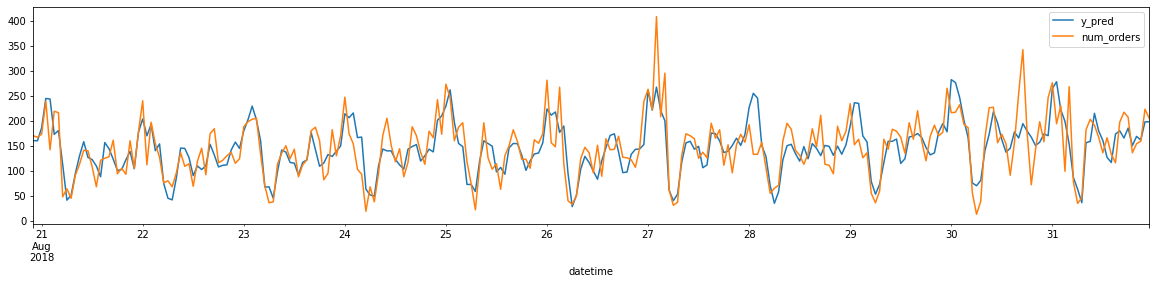

In [104]:
comparison = pd.DataFrame(y_pred, columns=['y_pred'], index=y_test.index).join(y_test)

comparison.plot(figsize=(20,4))


### Из графика видно, что основные неточности наблюдаются в точках резкого, отличающегося от основного распределения, роста числа заказов.

Спрогнозируем временные ряды без обучения. Новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1)

In [37]:
pred_previous = y_test.shift(fill_value=y_train.iloc[-1])
mean_squared_error(y_test, pred_previous) ** 0.5 

59.91893019312613

## Выводы

1. Создали модель, прогнозирующую количество заказов такси
2. Метрика модели составляет 38,95, что не превышает требуемое значение в 48
3. Модель проверена на адекватность путем сравнения с прогнозированием без обучения